# Simulation Sample Preparation

In this notebook I setup the different samples I'm going to use for each experiment to test the spaceNNtime neural net.

<a name="Home3"></a>

## Contents

0. [ Library and packages ](#Lib)
1. [ Functions ](#Fun)
    + 1. [Python Functions](#Pyf)
    + 2. [R Functions](#Rfu)
2. [ Tree Preprocessing ](#Tre)
    + 1. [ Input tree structure data from SLiM simulations ](#Inp)
    + 2. [ Types of individuals and subsampling "Remembered" individuals ](#Rem)
    + 3. [ Metadata ](#Met)
    + 4. [ Recapatitation ](#Rec)
    + 5. [ Mutation ](#Mut)
    + 6. [ Simplification ](#Sip)
3. [ Sampling Preparation ](#SPr)
    + 1. [ Best Case Scenario ](#BCS)
    + 2. [ Downsampling ](#Dow)
    + 3. [ Missing Space Reference Population ](#SRe)
    + 4. [ Missing Time Reference Population ](#TRe)
    + 5. [ Real MesoNeo data ](#Rea)
    + 6. [ Decreasing SNP density ](#Snp)
    + 7. [ Only location and only time ](#Onl)
    + 8. [ Genotype Likelihoods ](#GLs)

<a name="Lib"></a>
## 0. Library and packages

In [1]:
import sys
import pandas as pd
import numpy as np
import tskit
import msprime
import pyslim
import collections
import simGL

from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

sys.path.append('../scripts/')

from spacetime_templates import *

%load_ext rpy2.ipython
pandas2ri.activate()

In [2]:
%%R
.libPaths()

[1] "/maps/projects/racimolab/people/qxz396/miniconda3/envs/spaceNNtime/lib/R/library"


In [3]:
%%R
.libPaths(c("/maps/projects/racimolab/people/qxz396/spaceNNtime/renv/library/R-4.1/x86_64-redhat-linux-gnu", "/tmp/Rtmp9Hi1cZ/renv-system-library"))

library(ggplot2)
library(cowplot)
library(tidyverse)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1
✔ purrr   0.3.4     

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [4]:
%%R
.libPaths()

[1] "/maps/projects/racimolab/people/qxz396/spaceNNtime/renv/library/R-4.1/x86_64-redhat-linux-gnu"
[2] "/maps/projects/racimolab/people/qxz396/miniconda3/envs/spaceNNtime/lib/R/library"             



[<img src="arrow.png" width="100" style="float: left;">](#Home3) &nbsp;

&nbsp;

<a name="Fun"></a>
## 1. Functions

<a name="Pfu"></a>
### A. Python Functions

In [5]:
def get_remembered_ind(ts):
    '''
    Def:
        For a given tree structure, returns the individual ids corresponding to "remembered" individuals
    Input:
        - ts : tree structure
    Output:
        - remembered_ind : list with individuals ids
    '''
    remembered_ind = []
    for i in ts.individuals():
        if i.flags in [pyslim.INDIVIDUAL_ALIVE+pyslim.INDIVIDUAL_REMEMBERED, pyslim.INDIVIDUAL_RETAINED+pyslim.INDIVIDUAL_REMEMBERED, pyslim.INDIVIDUAL_REMEMBERED]:
            remembered_ind.append(i.id)
    return remembered_ind

def get_metadata(ts, ind_list = None):
    '''
    Def :
        From a given tree, it retrieves information about:
            - inid : individual ID
            - flag : individual flag
            - loc1 : x coordinate location
            - loc2 : y coordinate location
            - nod1 : first node's ID corresponding to one of the haplotypes of the individual
            - nod2 : second node's ID corresponding to one of the haplotypes of the individual
            - indp : individuals pedigree ID (invariable identifier that persists tree alterations unlike individual's ID)
            - popu : population index number
            - n1id : first node's SLiM ID (invariable identifier that persists tree alterations unlike node's ID)
            - n2id : second node's SLiM ID (invariable identifier that persists tree alterations unlike node's ID)
    Input :
        - ts       : tree structure
        - ind_list : list of individual ID's for which the metadata should be retrieved for. If no list is provided, the metadata
                     is going to be retrieved for all individuals in the tree.
    Output : 
        - df : pandas DataFrame (n_ind, n_atributes) with the metadata for all individuals of "ts" (or limited to individuals in "ind_list")
               with all the information explained in the definition of the function.
    '''
    inid, flag, loc1, loc2, nod1, nod2, indp, popu, time, n1id, n2id, = [], [], [], [], [], [], [], [], [], [], []

    if not ind_list:
        ind_list = [i.id for i in ts.individuals()]
    
    for i in range(len(ind_list)):
        inid.append(int(ind_list[i]))
        flag.append(int(ts.individual(ind_list[i]).flags))
        loc1.append(ts.individual(ind_list[i]).location[0])
        loc2.append(ts.individual(ind_list[i]).location[1])
        nod1.append(int(ts.individual(ind_list[i]).nodes[0]))
        if len(ts.individual(ind_list[i]).nodes) == 2:
            nod2.append(int(ts.individual(ind_list[i]).nodes[1]))
        else:
            nod2.append(-1)
        indp.append(int(ts.individual(ind_list[i]).metadata['pedigree_id']))
        popu.append(int(ts.individual(ind_list[i]).metadata['subpopulation']))
        time.append(ts.node(nod1[-1]).time)
        n1id.append(int(ts.node(nod1[-1]).metadata['slim_id']))
        if len(ts.individual(ind_list[i]).nodes) == 2:
            n2id.append(int(ts.node(nod2[-1]).metadata['slim_id']))
        else:
            n2id.append(-1)

    df = pd.DataFrame(np.array([inid,   indp ,  flag ,  loc1 ,  loc2 ,  time ,  nod1 ,  nod2 ,  popu ,  n1id ,  n2id]).T, 
                      columns=["inid", "indp", "flag", "loc1", "loc2", "time", "nod1", "nod2", "popu", "n1id", "n2id"])

    df = df.astype({"inid" : "int", "indp" : "int", "flag" : "int", "loc1" : "float", "loc2" : "float", "time" : "float",
                    "nod1" : "int", "nod2" : "int", "popu" : "int", "n1id" : "int", "n2id" : "int"})
    
    return df


def all_a_in_b(list1, list2):
    '''
    Def : 
        Function to test that ALL instances of "list1" appear in "list2". 
    Input : 
        - list1 : numpy array (n, )
        - list2 : numpy array (m, )
    Output:
        - boolean value that confirms if ALL instances of "list1" are in "list2".
    '''
    list1.sort()
    list2.sort()
    i = 0
    j = 0
    while i < len(list1) and j < len(list2):
        if list1[i] == list2[j]:
            i += 1
            j += 1
        else:
            j += 1

    return i == len(list1)

def update_metadata(old, new):
    '''
    Def: 
        Using individual pedigree ID, the individual ID and the nodes IDs of an old dataset are updated from a new dataset. 
        This function is handy after running "pyslim.simplify()" on a tree.
    Input :
        - old : pandas DataFrame with the metadata of a tree structure obtained from the function "get_metadata()".
        - new : pandas DataFrame with the metadata of a tree structure obtained from the function "get_metadata()".
    Output : 
        - update : pandas DataFrame that contains the infromation in the old dataset, but with the new information from the 
                   new dataset about the "inid", "nod1" and "nod2"
    '''
    merged = pd.merge(old, new[["indp", "inid", "nod1", "nod2"]], on = "indp")
    update = get_metadata(ts, remembered_ind)
    update["inid"] = merged["inid_y"]
    update["nod1"] = merged["nod1_y"]
    update["nod2"] = merged["nod2_y"]
    
    return update

def tr2ms(
    tree_sequence,
    output,
    print_trees=False,
    precision=4,
    num_replicates=1,
    write_header=True,
):
    """
    Write ``ms`` formatted output from the genotypes of a tree sequence
    or an iterator over tree sequences. Usage:
    .. code-block:: python
        import tskit as ts
        tree_sequence = msprime.simulate(
            sample_size=sample_size,
            Ne=Ne,
            length=length,
            mutation_rate=mutation_rate,
            recombination_rate=recombination_rate,
            random_seed=random_seed,
            num_replicates=num_replicates,
        )
        with open("output.ms", "w") as ms_file:
            ts.write_ms(tree_sequence, ms_file)
    :param ts tree_sequence: The tree sequence (or iterator over tree sequences) to
        write to ms file
    :param io.IOBase output: The file-like object to write the ms-style output
    :param bool print_trees: Boolean parameter to write out newick format trees
        to output [optional]
    :param int precision: Numerical precision with which to write the ms
        output [optional]
    :param bool write_header: Boolean parameter to write out the header. [optional]
    :param int num_replicates: Number of replicates simulated [required if
        num_replicates used in simulation]
    The first line of this ms-style output file written has two arguments which
    are sample size and number of replicates. The second line has a 0 as a substitute
    for the random seed.
    """
    if not isinstance(tree_sequence, collections.abc.Iterable):
        tree_sequence = [tree_sequence]

    for i, tree_seq in enumerate(tree_sequence):

        if not i:
            print(
                f"ms {tree_seq.sample_size} {num_replicates}\n0",
                file=output,
            )

        print("\n//", file=output)
        if print_trees:
            if len(tree_seq.trees()) == 1:
                tree = next(tree_seq.trees())
                newick = tree.newick(precision=precision)
                print(newick, file=output)
            else:
                for tree in tree_seq.trees():
                    newick = tree.newick(precision=precision)
                    print(f"[{tree.span:.{precision}f}]", newick, file=output)

        else:
            print("here")
            biallelic = [] 
            positions = []
            print("checking for biallelic alleles")
            for i, v in enumerate(ts.variants()):
                if len(v.alleles) < 3:
                    biallelic.append(True)
                    positions.append(v.position / (tree_seq.sequence_length))
                else:
                    biallelic.append(False)
                    
            s = np.array(biallelic).sum
            print("there are {} biallelic alleles".format(s))
            sys.exit()
            print("segsites:", s, file=output)
            if s != 0:
                print("positions: ", end="", file=output)
                for position in positions:
                    print(f"{position:.{precision}f}", end=" ", file=output)
                print(file=output)

                genotypes = tree_seq.genotype_matrix()
                
                for k in range(tree_seq.num_samples):
                    tmp_str = "".join([str(g) for g in ts.genotype_matrix()[biallelic, k]])
                    if set(tmp_str).issubset({"0", "1", "-"}):
                        print(tmp_str, file=output)
                    else:
                        raise ValueError(
                            "This tree sequence contains non-biallelic"
                            "SNPs and is incompatible with the ms format!"
                        )
            else:
                print(file=output)

<a name="Rfu"></a>
### B. R Functions

[<img src="arrow.png" width="100" style="float: left;">](#Home3) &nbsp;

&nbsp;

<a name="Tre"></a>
## 2. Tree Preprocessing

<a name="Inp"></a>
### A. Input tree structure data from SLiM simulations


In [84]:
ts = pyslim.load("/projects/racimolab/people/qxz396/spaceNNtime/sandbox/europe/slendr/output_ts.trees")
ts

[<img src="arrow.png" width="100" style="float: left;">](#Home3) &nbsp;

&nbsp;

<a name="Rem"></a>
### B. Types of individuals and subsampling "Remembered" individuals

We can see that the number of "sampled nodes" from the tree summary above is not the same than the sampled individuals that we scheduled for to `SLiM` with `slendr` (3,000 individuals). This is because `SLiM` "remembers" multiple types of individuals. 

1. **Alive:** These are the individuals that make it to the last generations and that are considered to be alive.
2. **Retained:** Individuals that might not be diploid and are only remembered to know the ancestry of other nodes but they are not studied directly.
3. **Remembered:** Individuals that are "dead" but that are sampled as if in real live we dug up a fosil. 


About that, there is more information in this [link](https://pyslim.readthedocs.io/en/latest/introduction.html#who-and-what-is-in-the-tree-sequence), this [link](https://pyslim.readthedocs.io/en/latest/tutorial.html#historical-individuals) and this [link](https://tskit.dev/pyslim/docs/latest/introduction.html).

Each individual will have an associated flag in order to know which category they belong to. The flags can be known by running the following command:


In [85]:
print(("Alive      :  {}\nRetained   : {}\nRemembered : {}").format(pyslim.INDIVIDUAL_ALIVE, pyslim.INDIVIDUAL_RETAINED, pyslim.INDIVIDUAL_REMEMBERED))

Alive      :  65536
Retained   : 262144
Remembered : 131072


However, a given individual can have multiple flags with codes added together. Here you have all the combinations:

In [86]:
print(("Alive + Retained      : {}\nAlive + Remembered    : {}\nRetained + Remembered : {}").format(pyslim.INDIVIDUAL_ALIVE+pyslim.INDIVIDUAL_RETAINED, pyslim.INDIVIDUAL_ALIVE+pyslim.INDIVIDUAL_REMEMBERED, pyslim.INDIVIDUAL_RETAINED+pyslim.INDIVIDUAL_REMEMBERED))


Alive + Retained      : 327680
Alive + Remembered    : 196608
Retained + Remembered : 393216


We can see here the example of one individual. This particular individual had the flag corresponding to Alive + Retained.

In [87]:
ts.individual(0)

Individual(id=0, flags=327680, location=array([407.05413635,  45.6115021 ,   0.        ]), parents=array([], dtype=int32), nodes=array([29884, 29885], dtype=int32), metadata={'pedigree_id': 10514698, 'age': -1, 'subpopulation': 1, 'sex': -1, 'flags': 0})

The chunk below shows how many individuals there are for each flag and combinations of flags.

In [88]:
num_fla = {

 65536 : "Alive",
262144 : "Retained",
131072 : "Remembered",
327680 : "Alive + Retained",
196608 : "Alive + Remembered",
393216 : "Retained + Remembered",
393216 : "Retained + Remembered"
}

counts = {}

for i in ts.individuals():
    if i.flags not in counts:
        counts[i.flags] = 0
    counts[i.flags] += 1

for x in counts:
    print("{} : {}".format(num_fla[x], counts[x]))

Alive + Retained : 5000
Retained : 39219
Retained + Remembered : 14942


In my case, I only want to keep the ones with Remembered flag, which correspond to the ones I scheduled to `SLiM` to be sampled by `slendr`.

In [89]:
remembered_ind = get_remembered_ind(ts)
np.array(remembered_ind)

array([ 5235,  5236,  5237, ..., 52125, 52180, 52181])

[<img src="arrow.png" width="100" style="float: left;">](#Home3) &nbsp;

&nbsp;

<a name="Met"></a>
### C. Metadata

There is lots of information associated to a given individual, as we can see in the next chunk. Important information for this project would be an individuals location, sampling time and the nodes a given individual corresponds to, among others.

In [90]:
ts.individual(remembered_ind[0])

Individual(id=5235, flags=393216, location=array([5.11517148e+002, 1.26432935e+002, 2.13224844e-264]), parents=array([], dtype=int32), nodes=array([0, 1], dtype=int32), metadata={'pedigree_id': 109243, 'age': -1, 'subpopulation': 2, 'sex': -1, 'flags': 0})

The nodes of that individual also have interesting information such as the sampling time.

In [91]:
print(ts.node(0))
print(ts.node(1))

Node(id=0, flags=1, time=1698.0, population=2, individual=5235, metadata={'slim_id': 218486, 'is_null': False, 'genome_type': 0})
Node(id=1, flags=1, time=1698.0, population=2, individual=5235, metadata={'slim_id': 218487, 'is_null': False, 'genome_type': 0})


I create a function that puts all this information in a pandas dataframe. You can input a list with the ID of individuals of interest (in my case, that can be the list with "remembered" individuals of a tree). But if such a list is not provided, the metadata is going to be returned for all individuals in the tree structure.

In [92]:
ts_metadata = get_metadata(ts, remembered_ind)
ts_metadata

,inid,indp,flag,loc1,loc2,time,nod1,nod2,popu,n1id,n2id
0,5235,109243,393216,511.517148,126.432935,1698.0,0,1,2,218486,218487
1,5236,109420,393216,460.757445,75.331444,1698.0,2,3,2,218840,218841
2,5237,109061,393216,476.029319,69.676202,1698.0,4,5,2,218122,218123
3,5238,109466,393216,459.548226,90.574841,1698.0,6,7,2,218932,218933
4,5239,109132,393216,518.778158,87.438188,1698.0,8,9,2,218264,218265
...,...,...,...,...,...,...,...,...,...,...,...
14937,52123,10433437,393216,363.537543,198.570501,17.0,29874,29875,5,20866874,20866875
14938,52124,10433214,393216,229.566593,238.798127,17.0,29876,29877,5,20866428,20866429
14939,52125,10433217,393216,335.596762,337.900800,17.0,29878,29879,5,20866434,20866435
14940,52180,10439670,393216,261.049153,296.326152,16.0,29880,29881,5,20879340,20879341


[<img src="arrow.png" width="100" style="float: left;">](#Home3) &nbsp;

&nbsp;

<a name="Rec"></a>
### D. Recapatitation

Sometimes, all the trees that were generated by SLiM do not coalesce to a single individual which can be problematic. In order to solve this issue, we can recapitate the trees which will create nodes backward in time in order to get a fully coalesced tree. For that we need to indicate the sample size and recombination rate. Because we have an initial "African" population, we can use it's population size and set recombination to 0 since we don't want recombination to act in our simulated loci. 

In [93]:
c = 0
for tree in ts.trees():
    if tree.has_multiple_roots:
        c += 1
        #print("Tree {} has not coalesced".format(tree.index))
        
if not c:
    print("All trees coalesced!")
else:
    print("{} trees didn't coalesced".format(c))

7403 trees didn't coalesced


In the next chunk I recapitate the tree and compare its atributes with the original tree.

In [94]:
ts_r = ts.recapitate(recombination_rate=1e-8, Ne=3000)
ts_r

In [95]:
ts

Compared to the initial tree, we can see that the recapitated tree has some more edges and nodes showing that the nodes of the original tree have coalesced. 

We can ask if the tree now coalseces.

In [96]:
c = 0
for tree in ts_r.trees():
    if tree.has_multiple_roots:
        c += 1
        #print("Tree {} has not coalesced".format(tree.index))
        
if not c:
    print("All trees coalesced!")
else:
    print("{} trees didn't coalesced".format(c))

All trees coalesced!


A sanity check is to compare the individual pedigree from the original tree `ts` with the recapitated tree `ts_r` to see that the information for the different individuals is kept after this process

In [97]:
ts_metadata["indp"].to_numpy() == get_metadata(ts_r, remembered_ind)["indp"].to_numpy()

array([ True,  True,  True, ...,  True,  True,  True])

[<img src="arrow.png" width="100" style="float: left;">](#Home3) &nbsp;

&nbsp;

<a name="Mut"></a>
### E. Mutation

Now, we can sprinkle some neutral mutations in our tree using `msprime`, setting a mutation rate.

In [98]:
ts_r_m = msprime.sim_mutations(ts_r, rate=1e-8, keep=True)
ts_r_m

We can see from the summary that we have mutations in our tree. 

[<img src="arrow.png" width="100" style="float: left;">](#Home3) &nbsp;

&nbsp;

<a name="Sip"></a>
### F. Simplification

We still have many more individuals in our tree (21,243) than the ones we actually want to sample (3,000). Tree structures can be simplified to a subset of nodes that we select for. For that, we can use the function `ts.simplify()` and give as an argument the list of nodes we want to keep.

These nodes are obtained from the metadata file generated with `get_metadata()` and inputing also the "remembered" individual IDs.

In [99]:
remembered_nod = get_metadata(ts_r_m, remembered_ind)[["nod1", "nod2"]].to_numpy().reshape(-1).astype(int)
print("Nodes : ", remembered_nod.shape[0], ", Individuals : ", remembered_nod.shape[0]//2)
remembered_nod

Nodes :  29884 , Individuals :  14942


array([    0,     1,     2, ..., 29881, 29882, 29883])

In [100]:
ts_r_m_s = ts_r_m.simplify(remembered_nod)
ts_r_m_s

We still see that we have many more individuals than what we want to sample. This is because individuals that represent the coalescence of different nodes are still kept by the tree.



After simplifying the tree, the individual and node IDs change, and their associated metadata gets lost from the tree structure

In [101]:
np.array([i.id for i in ts_r_m_s.individuals()])

array([    0,     1,     2, ..., 45536, 45537, 45538])

In [102]:
np.array(remembered_ind)

array([ 5235,  5236,  5237, ..., 52125, 52180, 52181])

In [103]:
np.array([n.id for n in ts_r_m_s.nodes()])

array([    0,     1,     2, ..., 61240, 61241, 61242])

In [104]:
np.array(remembered_nod)

array([    0,     1,     2, ..., 29881, 29882, 29883])

There is a single metadata information that does not get altered which is the `pedigree_id` for individuals and `slim_id`for nodes. 

Here, I check that the `pedigree_id` from the old tree for the nodes I want to keep are still in the new tree. The same for the `pedigree_id`.

In [105]:
all_a_in_b(get_metadata(ts, remembered_ind)["indp"].to_list(), get_metadata(ts_r_m_s)["indp"].to_list())

True

In [106]:
nid_new = get_metadata(ts_r_m_s)[["n1id", "n2id"]].to_numpy().reshape(-1)
nid_new = nid_new[nid_new != -1].tolist()

nid_old = get_metadata(ts, remembered_ind)[["n1id", "n2id"]].to_numpy().reshape(-1)
nid_old = nid_old[nid_old != -1].tolist()

all_a_in_b(nid_old, nid_new)

True

In order to retain the metadata information from the original tree structure but using the new individuals and nodes IDs, I created a function to update a old version of the metadata file with the new nodes and individuals IDs.

In [107]:
updated_meta = update_metadata(get_metadata(ts, remembered_ind), get_metadata(ts_r_m_s))
updated_meta

,inid,indp,flag,loc1,loc2,time,nod1,nod2,popu,n1id,n2id
0,76,109243,393216,511.517148,126.432935,1698.0,0,1,2,218486,218487
1,77,109420,393216,460.757445,75.331444,1698.0,2,3,2,218840,218841
2,78,109061,393216,476.029319,69.676202,1698.0,4,5,2,218122,218123
3,79,109466,393216,459.548226,90.574841,1698.0,6,7,2,218932,218933
4,80,109132,393216,518.778158,87.438188,1698.0,8,9,2,218264,218265
...,...,...,...,...,...,...,...,...,...,...,...
14937,45534,10433437,393216,363.537543,198.570501,17.0,29874,29875,5,20866874,20866875
14938,45535,10433214,393216,229.566593,238.798127,17.0,29876,29877,5,20866428,20866429
14939,45536,10433217,393216,335.596762,337.900800,17.0,29878,29879,5,20866434,20866435
14940,45537,10439670,393216,261.049153,296.326152,16.0,29880,29881,5,20879340,20879341


In [108]:
%%bash 

mkdir -p ../sandbox/europe/processed_tree

In [109]:
updated_meta.to_csv(path_or_buf="../sandbox/europe/processed_tree/metadata.csv", sep=',', header=True, index=False)
ts_r_m_s.dump("../sandbox/europe/processed_tree/tree.trees")

I'll also save the tree in `ms` format so that in later steps I'll be able to compute the

In [ ]:
#with open("../sandbox/europe/processed_tree/tree.ms", "w") as output:
#    tr2ms(ts_r_m_s, output)


[<img src="arrow.png" width="100" style="float: left;">](#Home3) &nbsp;

&nbsp;


<a name="SPr"></a>
## 3. Sampling Preparation


<a name="BCS"></a>
### A. Best Case Scenario

This experiment is going to use all "remembered individuals". There is little to be done. I'll just create a dictionary with sets of test individuals (3 per set) which none of the individuals will appear in other sets. For each test set, there will be an associated training and validatig set with proportions 9:1. Then, I'll save all this combinations as a dictinary in a `yaml` file format. This will be the input of the spaceNNtime neural network so that it will generate the allele counts for those individuals that appear on those sets and use them acordingly for training, validating and testing. 


In [37]:
%%bash

mkdir -p ../sandbox/europe/spaceNNtime/exp001

In [38]:
updated_meta.to_csv(path_or_buf="../sandbox/europe/spaceNNtime/exp001/metadata.csv", sep=',', header=True, index=False)

np.random.seed(1234)
_ = get_tra_val_tes(updated_meta["inid"].to_numpy(), file = "../sandbox/europe/spaceNNtime/exp001/exp001.yaml", 
                overwrite = True, n_tes = 3, p_tra = 0.9, max_tes_groups = 100)


[<img src="arrow.png" width="100" style="float: left;">](#Home3) &nbsp;

&nbsp;

<a name="Dow"></a>
### B. Downsampling

In [39]:
%%bash

mkdir -p ../sandbox/europe/spaceNNtime/exp002
mkdir -p ../sandbox/europe/spaceNNtime/exp003
mkdir -p ../sandbox/europe/spaceNNtime/exp004
mkdir -p ../sandbox/europe/spaceNNtime/exp005
mkdir -p ../sandbox/europe/spaceNNtime/exp006
mkdir -p ../sandbox/europe/spaceNNtime/exp007

In [40]:
%%time

np.random.seed(1234)

for downsamp, exp_id in zip([10000, 5000, 1500, 1000, 500, 250], [2, 3, 4, 5, 6, 7]):
    print(exp_id)
    tmp_meta = updated_meta.sample(n=downsamp, replace=False, weights=None)
    tmp_meta.sort_values(by=['inid'])
    tmp_meta.to_csv(path_or_buf="../sandbox/europe/spaceNNtime/exp00{}/metadata.csv".format(exp_id), sep=',', header=True, index=False)
    _ = get_tra_val_tes(tmp_meta["inid"].to_numpy(), file = "../sandbox/europe/spaceNNtime/exp00{}/exp00{}.yaml".format(exp_id, exp_id), 
                overwrite = True, n_tes = 3, p_tra = 0.9, max_tes_groups = 100)


2
3
4
5
6
7
CPU times: user 29.1 s, sys: 347 ms, total: 29.4 s
Wall time: 29.6 s


[<img src="arrow.png" width="100" style="float: left;">](#Home3) &nbsp;

&nbsp;

<a name="SRe"></a>
### C. Missing Space Reference Population

[<img src="arrow.png" width="100" style="float: left;">](#Home3) &nbsp;

&nbsp;

<a name="TRe"></a>
### D. Missing Time Reference Population

[<img src="arrow.png" width="100" style="float: left;">](#Home3) &nbsp;

&nbsp;

<a name="Rea"></a>
### E. Real MesoNeo data

In this experiment, I'll try to match the sampling distribution in the temporal dimention of the MesoNeo data. For that, I have explored the distribution in that axis in the real data and grouped samples in windows of 1,000 years and counted how many samples do I get for each temporal bin. I obtained the data below.

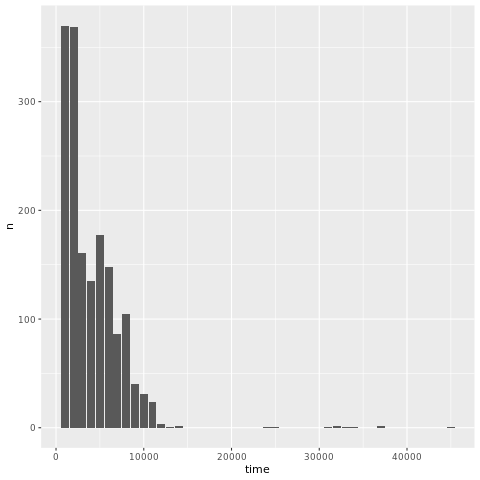

In [41]:
%%R

mesoneo_temp_bins_n = data.frame(time = c(1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000,  9000, 10000, 11000, 12000, 13000, 14000, 24000, 25000, 31000, 32000, 33000, 34000, 37000, 45000),
                                 n     = c( 370,  369,  161,  135,  177,  148,   86,  105,    40,    31,    24,     3,     1,     2,     1,     1,     1,     2,     1,     1,     2,     1)) 
mesoneo_temp_bins_n %>%
    ggplot() +
    geom_bar(stat = "identity", aes(x = time, y = n))

In [42]:
%%R

mesoneo_temp_bins_n %>%
    summarize(n = sum(n))

     n
1 1662


In [43]:
%%R -i updated_meta

mesoneo_downsampled = data.frame()

set.seed(1234)

for(t in mesoneo_temp_bins_n$time){
    n_rea = mesoneo_temp_bins_n %>% filter(time == t) %>% pull(n)
    n_sim = updated_meta %>% filter(t <= time*30, t+1000 > time*30) %>% nrow()
    if(n_sim < n_rea){
        mesoneo_downsampled = rbind(mesoneo_downsampled, updated_meta %>% filter(t <= time*30, t+1000 > time*30))
    }else{
        mesoneo_downsampled = rbind(mesoneo_downsampled, updated_meta %>% filter(t <= time*30, t+1000 > time*30) %>% sample_n(n_rea, replace = FALSE))
    }
                                     
}


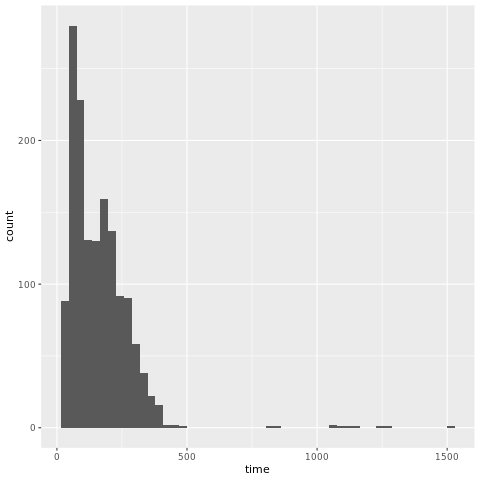

In [44]:
%%R

mesoneo_downsampled %>% 
    ggplot() +
    geom_histogram(aes(x = time), bins = 50)

In [45]:
%%R

mesoneo_downsampled %>%
    dim()

[1] 1484   11


In [46]:
mesoneo_downsampled = r['mesoneo_downsampled']
mesoneo_downsampled = mesoneo_downsampled.sort_values(by=['inid'])
mesoneo_downsampled

,inid,indp,flag,loc1,loc2,time,nod1,nod2,popu,n1id,n2id
1593,4362,739498,393216,584.846910,132.576151,1518.0,3186,3187,2,1478996,1478997
3885,10565,1642646,393216,648.107526,310.626391,1260.0,7770,7771,2,3285292,3285293
3954,10744,1670842,393216,645.830093,290.142438,1252.0,7908,7909,2,3341684,3341685
4987,13587,2076740,393216,662.912588,281.553904,1136.0,9974,9975,2,4153480,4153481
5095,13847,2112024,393216,651.348886,316.269597,1126.0,10190,10191,2,4224048,4224049
...,...,...,...,...,...,...,...,...,...,...,...
14798,45341,10347914,393216,190.533153,253.813376,34.0,29596,29597,5,20695828,20695829
14799,45342,10349071,393216,400.119998,203.466672,34.0,29598,29599,5,20698142,20698143
14800,45343,10349354,393216,250.950505,223.441605,34.0,29600,29601,5,20698708,20698709
14801,45344,10347905,393216,186.480498,267.141073,34.0,29602,29603,5,20695810,20695811


In [47]:
%%bash

mkdir -p ../sandbox/europe/spaceNNtime/exp008

In [48]:
mesoneo_downsampled.to_csv(path_or_buf="../sandbox/europe/spaceNNtime/exp00{}/metadata.csv".format(8), sep=',', header=True, index=False)
_ = get_tra_val_tes(mesoneo_downsampled["inid"].to_numpy(), file = "../sandbox/europe/spaceNNtime/exp00{}/exp00{}.yaml".format(8, 8), 
                    overwrite = True, n_tes = 3, p_tra = 0.9, max_tes_groups = 100)

[<img src="arrow.png" width="100" style="float: left;">](#Home3) &nbsp;

&nbsp;

<a name="Snp"></a>
### F. Decreasing SNP density


In [49]:
%%bash

mkdir -p ../sandbox/europe/spaceNNtime/exp009
mkdir -p ../sandbox/europe/spaceNNtime/exp010
mkdir -p ../sandbox/europe/spaceNNtime/exp011
mkdir -p ../sandbox/europe/spaceNNtime/exp012

In [50]:
ls ../sandbox/europe/spaceNNtime/exp004/

exp004.yaml  metadata.csv


In [51]:
%%bash

for x in 09 `seq 10 12`;
do
    echo ${x}
    cp ../sandbox/europe/spaceNNtime/exp004/exp004.yaml ../sandbox/europe/spaceNNtime/exp0${x}/exp0${x}.yaml
    cp ../sandbox/europe/spaceNNtime/exp004/metadata.csv ../sandbox/europe/spaceNNtime/exp0${x}/metadata.csv
done;

09
10
11
12


[<img src="arrow.png" width="100" style="float: left;">](#Home3) &nbsp;

&nbsp;

<a name="Onl"></a>
### G. Only location and only time

In [52]:
%%bash

mkdir -p ../sandbox/europe/spaceNNtime/exp013
mkdir -p ../sandbox/europe/spaceNNtime/exp014

In [53]:
%%bash

for x in `seq 13 14`;
do
    echo ${x}
    cp ../sandbox/europe/spaceNNtime/exp004/exp004.yaml ../sandbox/europe/spaceNNtime/exp0${x}/exp0${x}.yaml
    cp ../sandbox/europe/spaceNNtime/exp004/metadata.csv ../sandbox/europe/spaceNNtime/exp0${x}/metadata.csv
done;

13
14


[<img src="arrow.png" width="100" style="float: left;">](#Home3) &nbsp;

&nbsp;

<a name="GLs"></a>
### H. Genotype Likelihoods

In this chuck I'll produce Genotype Likelihoods simulated using `simGL`. 

In [5]:
%%bash

pwd

/maps/projects/racimolab/people/qxz396/spaceNNtime/jupyternotebooks


In [116]:
e        = 0.005
ts       = pyslim.load("../sandbox/europe/processed_tree/tree.trees")
metadata = pd.read_csv("../sandbox/europe/spaceNNtime/exp{exp}/metadata.csv".format(exp = "004"))
gm       = allele_counts_from_simulations(ts, metadata, 1, False)
arc      = simGL.sim_allelereadcounts(gm = gm, mean_depth = 10., std_depth = 3., e = e, ploidy = 2, seed = 1234)
GL       = simGL.allelereadcounts_to_GL(arc = arc, e = e, ploidy = 2)[:, :, 0:3]

argsorGL = np.argsort(GL)

minGLidx = np.argmax(argsorGL == 0, axis = 2).reshape(-1)

dim1_idx = np.repeat(np.arange(GL.shape[0]), GL.shape[1])
dim2_idx = np.tile(np.arange(GL.shape[1]), GL.shape[0])
dim3_idx = np.argmax(np.argsort(GL) == 1, axis = 2).reshape(-1)
midGLval = GL[dim1_idx, dim2_idx, dim3_idx]

missing  = ((GL == 0).sum(axis = 2) == 3).reshape(-1)

minGLidx[missing] = -1
midGLval[missing] = max(midGLval)*2
GLmix = np.concatenate((minGLidx, midGLval)).reshape(2, midGLval.shape[0]).reshape(2, GL.shape[0], GL.shape[1]).transpose((1, 0, 2)).reshape(GL.shape[0]*2, GL.shape[1])

In [117]:
minGLidx

array([0, 0, 0, ..., 0, 0, 0])

In [118]:
midGLval

array([11.06357664, 22.81862682, 21.43567974, ...,  5.53178832,
       11.75505018, 12.44652372])

In [124]:
GL.shape

(1324, 1500, 3)

In [122]:
print(GLmix.shape)
GLmix

(2648, 1500)


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [11.06357664, 22.81862682, 21.43567974, ...,  8.98915602,
        11.75505018,  8.98915602],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 5.53178832, 15.21241788, 14.52094434, ...,  5.53178832,
        15.21241788,  8.98915602],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [10.3721031 , 15.21241788, 18.66978558, ...,  5.53178832,
        11.75505018, 12.44652372]])

Prove that this method works

In [115]:
np.concatenate((np.arange(3*5).reshape(3, 5).reshape(-1), np.arange(3*5).reshape(3, 5).reshape(-1))).reshape(2, 3, 5).transpose((1, 0, 2)).reshape(3*2, 5)


array([[ 0,  1,  2,  3,  4],
       [ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [10, 11, 12, 13, 14]])

array([ 0.        , 17.97831204,  0.        , ..., 13.66081555,
        0.        , 15.90389142])

In [86]:
np.concatenate((minGLidx, midGLval)).reshape(2, midGLval.shape[0]).T.reshape(-1).reshape(GL.shape[0]*2, GL.shape[1])

array([[ 0.        , 11.06357664,  0.        , ...,  8.98915602,
         0.        , 20.05273266],
       [ 0.        ,  9.68062956,  0.        , ..., 11.75505018,
         0.        ,  8.98915602],
       [ 0.        ,  4.67165953,  0.        , ..., 12.44652372,
         0.        , 18.66978558],
       ...,
       [ 0.        , 15.90389142,  0.        , ..., 15.21241788,
         0.        ,  8.98915602],
       [ 0.        , 10.3721031 ,  0.        , ..., 15.21241788,
         0.        , 22.12715328],
       [ 0.        , 14.52094434,  0.        , ..., 11.75505018,
         0.        , 12.44652372]])

In [48]:
GL.shape

(1324, 1500, 3)

In [125]:
np.__version__

'1.22.1'

In [130]:
def depth_per_haplotype(rng, mean_depth, std_depth, n_hap):
    if isinstance(mean_depth, np.ndarray):
        return mean_depth
    else:
        dp = np.full((n_hap, ), 0.0)
        while (dp <= 0).sum():
            n = (dp <= 0).sum()
            dp[dp <= 0] = rng.normal(loc = mean_depth, scale = std_depth, size=n)
        return dp

def refalt_int_encoding(gm, ref, alt):
    refalt_str                    = np.array([ref, alt])
    refalt_int                    = np.zeros(refalt_str.shape, dtype=int)
    refalt_int[refalt_str == "C"] = 1
    refalt_int[refalt_str == "G"] = 2
    refalt_int[refalt_str == "T"] = 3
    return refalt_int[gm.reshape(-1), np.repeat(np.arange(gm.shape[0]), gm.shape[1])].reshape(gm.shape)

In [133]:
seed = 1234
mean_depth = 30.0
std_depth = 5.0
ploidy = 2

ts       = pyslim.load("../sandbox/europe/processed_tree/tree.trees")
metadata = pd.read_csv("../sandbox/europe/spaceNNtime/exp{exp}/metadata.csv".format(exp = "004"))
gm       = allele_counts_from_simulations(ts, metadata, 1, False)


ref = np.full(gm.shape[0], "A")
alt = np.full(gm.shape[0], "C")

err = np.array([[1-e, e/3, e/3, e/3], [e/3, 1-e, e/3, e/3], [e/3, e/3, 1-e, e/3], [e/3, e/3, e/3, 1-e]])
rng = np.random.default_rng(seed)
#1. Depths (DP) per haplotype (h)
DPh = depth_per_haplotype(rng, mean_depth, std_depth, gm.shape[1])
#2. Sample depths (DP) per site per haplotype
DP  = rng.poisson(DPh, size=gm.shape)
#3. Sample correct and error reads per SNP per haplotype (Rh)
#3.1. Convert anc = 0/der = 1 encoded gm into "A" = 0, "C" = 1, "G" = 3, "T" = 4 basepair (bp) encoded gm 
gmbp = refalt_int_encoding(gm, ref, alt)
#3.2. Simulate allele read counts (ARC) per haplotype (h) per site (s)
arc  = rng.multinomial(DP, err[gmbp])
#4. Add n haplotype read allele counts (n = ploidy) to obtain read allele counts per genotype
arc.reshape(arc.shape[0], arc.shape[1]//ploidy, ploidy, arc.shape[2]).sum(axis = 2)

array([[[50,  0,  0,  0],
        [69,  0,  0,  0],
        [96,  0,  0,  1],
        ...,
        [47,  0,  0,  0],
        [47,  1,  0,  0],
        [51,  1,  0,  0]],

       [[55,  0,  0,  0],
        [63,  0,  1,  1],
        [95,  0,  0,  0],
        ...,
        [38,  0,  0,  0],
        [56,  0,  0,  0],
        [45,  0,  0,  0]],

       [[48,  0,  1,  0],
        [59,  1,  0,  0],
        [71,  0,  1,  0],
        ...,
        [57,  0,  0,  0],
        [61,  1,  0,  0],
        [48,  0,  0,  0]],

       ...,

       [[55,  0,  0,  0],
        [53,  0,  0,  0],
        [77,  0,  0,  0],
        ...,
        [60,  0,  0,  0],
        [61,  0,  0,  0],
        [56,  0,  0,  0]],

       [[57,  0,  0,  2],
        [82,  0,  1,  0],
        [62,  1,  0,  0],
        ...,
        [49,  0,  0,  0],
        [61,  0,  0,  0],
        [53,  0,  0,  0]],

       [[49,  0,  0,  0],
        [55,  0,  0,  0],
        [67,  0,  0,  0],
        ...,
        [47,  0,  0,  0],
        [57,  0

In [134]:
print(DP.shape)
DP

(1324, 3000)


array([[22, 28, 36, ..., 33, 22, 30],
       [21, 34, 38, ..., 30, 28, 17],
       [23, 26, 28, ..., 42, 21, 27],
       ...,
       [28, 27, 30, ..., 34, 26, 30],
       [22, 37, 40, ..., 37, 28, 25],
       [24, 25, 33, ..., 39, 33, 32]])

In [136]:
err[gmbp].shape

(1324, 3000, 4)

In [145]:
rng.multinomial(DP, err[gmbp])

array([[[22,  0,  0,  0],
        [27,  1,  0,  0],
        [35,  1,  0,  0],
        ...,
        [33,  0,  0,  0],
        [22,  0,  0,  0],
        [30,  0,  0,  0]],

       [[21,  0,  0,  0],
        [34,  0,  0,  0],
        [36,  0,  1,  1],
        ...,
        [30,  0,  0,  0],
        [28,  0,  0,  0],
        [17,  0,  0,  0]],

       [[23,  0,  0,  0],
        [26,  0,  0,  0],
        [28,  0,  0,  0],
        ...,
        [42,  0,  0,  0],
        [21,  0,  0,  0],
        [27,  0,  0,  0]],

       ...,

       [[27,  0,  1,  0],
        [27,  0,  0,  0],
        [30,  0,  0,  0],
        ...,
        [34,  0,  0,  0],
        [26,  0,  0,  0],
        [30,  0,  0,  0]],

       [[22,  0,  0,  0],
        [37,  0,  0,  0],
        [39,  0,  1,  0],
        ...,
        [37,  0,  0,  0],
        [28,  0,  0,  0],
        [25,  0,  0,  0]],

       [[24,  0,  0,  0],
        [25,  0,  0,  0],
        [33,  0,  0,  0],
        ...,
        [39,  0,  0,  0],
        [33,  0

In [144]:
result

array([[[21,  0,  0,  1],
        [28,  0,  0,  0],
        [36,  0,  0,  0],
        ...,
        [33,  0,  0,  0],
        [21,  0,  1,  0],
        [29,  0,  1,  0]],

       [[21,  0,  0,  0],
        [34,  0,  0,  0],
        [38,  0,  0,  0],
        ...,
        [30,  0,  0,  0],
        [28,  0,  0,  0],
        [17,  0,  0,  0]],

       [[23,  0,  0,  0],
        [26,  0,  0,  0],
        [28,  0,  0,  0],
        ...,
        [41,  0,  1,  0],
        [21,  0,  0,  0],
        [27,  0,  0,  0]],

       ...,

       [[27,  0,  0,  1],
        [27,  0,  0,  0],
        [29,  0,  1,  0],
        ...,
        [34,  0,  0,  0],
        [26,  0,  0,  0],
        [30,  0,  0,  0]],

       [[22,  0,  0,  0],
        [37,  0,  0,  0],
        [39,  0,  1,  0],
        ...,
        [37,  0,  0,  0],
        [28,  0,  0,  0],
        [24,  1,  0,  0]],

       [[24,  0,  0,  0],
        [25,  0,  0,  0],
        [33,  0,  0,  0],
        ...,
        [39,  0,  0,  0],
        [33,  0

[<img src="arrow.png" width="100" style="float: left;">](#Home3) &nbsp;

&nbsp;